In [59]:
import matplotlib.pyplot as plt
#plt.rcParams['pdf.fonttype'] = 42
import pandas as pd
from IPython.core.display import HTML
import numpy as np
%matplotlib inline

In [60]:
radius = pd.read_csv('Data\SAGE_SOUTH_2016-01-07-1307-8.csv', header=None, parse_dates={"Year" : [1]})
radius.index =(radius.Year +
               pd.to_timedelta(radius[2],unit='D') +  
               pd.to_timedelta(radius[3]//100-1,unit='H') + #minus one hour to set to UTC-8
               pd.to_timedelta(radius[3]%100,unit='m'))
#voltage to microns
#radius['8']=4*radius['8']
del radius['Year'], radius[0], radius[2], radius[3]
radius.tail()

,4,5,6,7,8,9,10,11,12
2016-01-08 11:00:00,685.19,1.9817,394.20,565.79,8.5876,92.481,-524.12,-243.75,14.40
2016-01-08 11:30:00,685.04,1.9816,394.29,565.76,8.5871,92.476,-510.99,-231.52,14.40
2016-01-08 12:00:00,685.13,1.9816,394.33,565.79,8.6419,92.474,-497.15,-221.94,14.36
2016-01-08 12:30:00,685.01,1.9265,394.33,565.73,8.9170,92.472,-504.03,-243.01,14.38
2016-01-08 13:00:00,685.06,1.8714,394.27,565.73,9.2471,92.471,-507.44,-263.87,14.40


In [61]:
#%% SPECIFY TIME RANGE OF SERIES
startDateTime = pd.to_datetime('2015-08-13 00:00:00')
stopDateTime = pd.to_datetime('2016-01-01 00:00:00')
radius = radius[(pd.to_datetime(radius.index) > startDateTime) & 
                (pd.to_datetime(radius.index) < stopDateTime)]


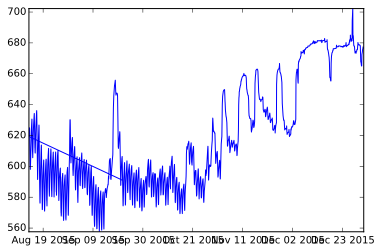

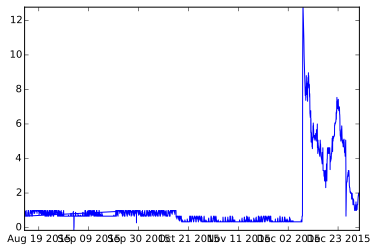

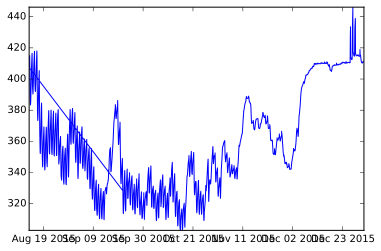

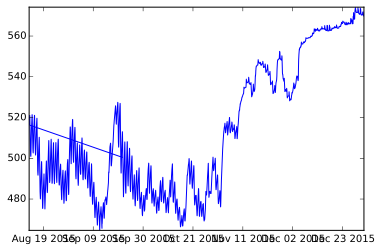

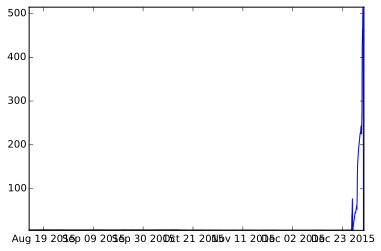

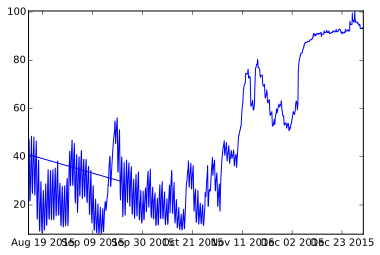

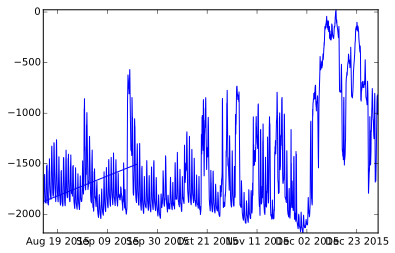

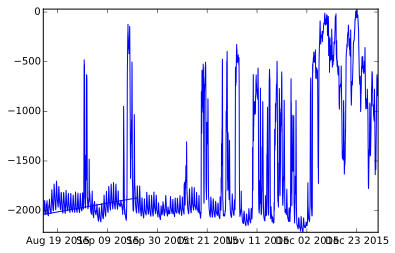

In [62]:
for i in range(4,12):
    plt.figure()
    plt.plot(radius.index, radius[i])
    plt.ylim( [min(radius[i]),max(radius[i])] )


In [63]:
range(4,10)

[4, 5, 6, 7, 8, 9]